__Modell för att prediktera typ av omgång, mått på svårighetsgrad__

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
from sklearn.model_selection import GridSearchCV 

In [48]:
# Necessary Sklearn objects used in the analysis
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

In [7]:
# Where to save the figures
PROJECT_ROOT_DIR = os.getcwd()
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR)

In [8]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [10]:
df1 = pd.read_excel('UtdelningsDataV75TillUffe_2019-03-11.xlsx')

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17994 entries, 0 to 17993
Data columns (total 37 columns):
Datum          17994 non-null datetime64[ns]
Utdelning      17994 non-null int64
Arstid         17994 non-null int64
Distans        17994 non-null int64
Startsatt      17994 non-null int64
Lopp           17994 non-null int64
Plac           17994 non-null int64
Hast           17994 non-null int64
V75PROC        17994 non-null float64
V_ODDS         17994 non-null float64
GRUPP          17994 non-null int64
VLP            17994 non-null float64
VNUM           17994 non-null int64
SVLP           17994 non-null float64
VSVLP          17994 non-null float64
VPN_SUM        17994 non-null float64
VPN_SUM_ORD    17994 non-null int64
VPK_SUM        17994 non-null float64
VPK_SUM_ORD    17994 non-null int64
VLPB           17994 non-null float64
SVLPB          17994 non-null float64
VSVLPB         17994 non-null float64
E_P            17994 non-null float64
E_P_Num        17994 non-null in

In [12]:
df1.head()

,Datum,Utdelning,Arstid,Distans,Startsatt,Lopp,Plac,Hast,V75PROC,V_ODDS,...,G_R,A_R,T_R,SP_R,ToR,P_R,TK_R,Ex_R,R_R,Ts_R
0,2016-08-13,2842,2,1,1,1,0,2,0.37,1.9,...,2.0,1.0,1.0,NaN,1.0,2.0,NaN,NaN,NaN,2
1,2016-08-13,2842,2,1,1,1,0,5,0.09,11.7,...,0.0,0.0,3.0,NaN,0.0,0.0,NaN,NaN,NaN,0
2,2016-08-13,2842,2,1,1,1,0,7,0.03,25.9,...,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,3
3,2016-08-13,2842,2,1,1,1,0,1,0.11,9.0,...,3.0,3.0,0.0,NaN,0.0,3.0,NaN,NaN,NaN,0
4,2016-08-13,2842,2,1,1,1,1,3,0.37,2.2,...,1.0,2.0,2.0,NaN,2.0,1.0,NaN,NaN,NaN,1


In [13]:
df1.Utdelning.describe()

count    1.799400e+04
mean     2.121313e+06
std      6.929704e+06
min      2.330000e+02
25%      7.944000e+03
50%      4.784000e+04
75%      4.746250e+05
max      4.284691e+07
Name: Utdelning, dtype: float64

In [14]:
# Skapar en unik nyckel på lopp: Gör om Datum och lopp till en sträng

df1['cdate'] = df1.Datum.astype('object')
df1['cLopp'] = df1.Lopp.astype('object')

In [15]:
df1['Key'] = df1['cdate'].astype(str) + df1['cLopp'].astype(str)

__Skapar en kopia, droppar de variabler som inte ska vara med i analysen samt sätter index__

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17994 entries, 0 to 17993
Data columns (total 40 columns):
Datum          17994 non-null datetime64[ns]
Utdelning      17994 non-null int64
Arstid         17994 non-null int64
Distans        17994 non-null int64
Startsatt      17994 non-null int64
Lopp           17994 non-null int64
Plac           17994 non-null int64
Hast           17994 non-null int64
V75PROC        17994 non-null float64
V_ODDS         17994 non-null float64
GRUPP          17994 non-null int64
VLP            17994 non-null float64
VNUM           17994 non-null int64
SVLP           17994 non-null float64
VSVLP          17994 non-null float64
VPN_SUM        17994 non-null float64
VPN_SUM_ORD    17994 non-null int64
VPK_SUM        17994 non-null float64
VPK_SUM_ORD    17994 non-null int64
VLPB           17994 non-null float64
SVLPB          17994 non-null float64
VSVLPB         17994 non-null float64
E_P            17994 non-null float64
E_P_Num        17994 non-null in

In [20]:
df1['Y'] = df1.Utdelning

In [21]:
df2 = df1[(df1.Datum > '2016-05-20')]. \
drop(['Utdelning','Arstid','Distans','Startsatt','Lopp','Plac','Hast','cdate','cLopp','VNUM','V_ODDS','GRUPP'], axis = 1). \
copy().set_index(['Key'])

In [22]:
len(df2)

17994

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17994 entries, 2016-08-13 00:00:001 to 2017-05-07 00:00:007
Data columns (total 28 columns):
Datum          17994 non-null datetime64[ns]
V75PROC        17994 non-null float64
VLP            17994 non-null float64
SVLP           17994 non-null float64
VSVLP          17994 non-null float64
VPN_SUM        17994 non-null float64
VPN_SUM_ORD    17994 non-null int64
VPK_SUM        17994 non-null float64
VPK_SUM_ORD    17994 non-null int64
VLPB           17994 non-null float64
SVLPB          17994 non-null float64
VSVLPB         17994 non-null float64
E_P            17994 non-null float64
E_P_Num        17994 non-null int64
E_N            17994 non-null float64
E_R            17994 non-null float64
E_U            17994 non-null float64
G_R            16243 non-null float64
A_R            15310 non-null float64
T_R            16317 non-null float64
SP_R           4730 non-null float64
ToR            15201 non-null float64
P_R            15903 non-n

__Delar upp i numeriska samt charachter attribut. Det är dessa som går in i modellen__

In [24]:
for var, typ in zip(df2.columns[:-1], df2.dtypes[:-1]):
    print(typ)

datetime64[ns]
float64
float64
float64
float64
float64
int64
float64
int64
float64
float64
float64
float64
int64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
int64


In [25]:
num_attribs = []
cat_attribs = []
for var, typ in zip(df2.columns[:-1], df2.dtypes[:-1]):
    if typ == 'object':
        cat_attribs.append(var)
    elif typ != 'datetime64[ns]':
        num_attribs.append(var)       

In [26]:
num_attribs

['V75PROC',
 'VLP',
 'SVLP',
 'VSVLP',
 'VPN_SUM',
 'VPN_SUM_ORD',
 'VPK_SUM',
 'VPK_SUM_ORD',
 'VLPB',
 'SVLPB',
 'VSVLPB',
 'E_P',
 'E_P_Num',
 'E_N',
 'E_R',
 'E_U',
 'G_R',
 'A_R',
 'T_R',
 'SP_R',
 'ToR',
 'P_R',
 'TK_R',
 'Ex_R',
 'R_R',
 'Ts_R']

In [27]:
len(num_attribs)

26

In [28]:
features_list = num_attribs
features_list

['V75PROC',
 'VLP',
 'SVLP',
 'VSVLP',
 'VPN_SUM',
 'VPN_SUM_ORD',
 'VPK_SUM',
 'VPK_SUM_ORD',
 'VLPB',
 'SVLPB',
 'VSVLPB',
 'E_P',
 'E_P_Num',
 'E_N',
 'E_R',
 'E_U',
 'G_R',
 'A_R',
 'T_R',
 'SP_R',
 'ToR',
 'P_R',
 'TK_R',
 'Ex_R',
 'R_R',
 'Ts_R']

__Gruppera på omgång och beräkna varians för varje omgång för varje ingående feature__

In [29]:
grouped = df2.groupby('Datum')

In [30]:
df_list = []
for var in features_list:
    df_list.append(grouped[var].var().to_frame())

In [31]:
df_list[1]

,VLP
Datum,
2016-05-21,22.451581
2016-05-28,27.951810
2016-05-29,68.394212
2016-06-04,90.679394
2016-06-11,20.386267
2016-06-12,33.672498
2016-06-18,59.331545
2016-06-26,55.487165
2016-07-02,33.110512


In [32]:
df_analys = df2.groupby('Datum').first()['Y'].to_frame()

In [33]:
df_analys = pd.concat([df_analys, df_list[1]], axis = 1)


In [34]:
# Skapar en dataframe av allt-konkatinerar

for df in df_list:
    df_analys = pd.concat([df_analys, df], axis = 1)



In [35]:
df_analys.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2016-05-21 to 2019-01-05
Data columns (total 28 columns):
Y              222 non-null int64
VLP            222 non-null float64
V75PROC        222 non-null float64
VLP            222 non-null float64
SVLP           222 non-null float64
VSVLP          222 non-null float64
VPN_SUM        222 non-null float64
VPN_SUM_ORD    222 non-null float64
VPK_SUM        222 non-null float64
VPK_SUM_ORD    222 non-null float64
VLPB           222 non-null float64
SVLPB          222 non-null float64
VSVLPB         222 non-null float64
E_P            222 non-null float64
E_P_Num        222 non-null float64
E_N            222 non-null float64
E_R            222 non-null float64
E_U            222 non-null float64
G_R            200 non-null float64
A_R            189 non-null float64
T_R            201 non-null float64
SP_R           58 non-null float64
ToR            187 non-null float64
P_R            196 non-null float64
TK_R           

__Nu bygger vi upp en pipeline__

In [36]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
# Denna klass måste vi göra för att särskilja numeriska variabler mot character variabler
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [37]:
# Pipeline för numeriska variabler
full_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median"))
    ])



In [40]:
len(df_analys)

222

In [66]:
df_analys.Y.describe()

count    2.220000e+02
mean     2.074251e+06
std      6.878348e+06
min      2.330000e+02
25%      7.733000e+03
50%      4.546450e+04
75%      4.334970e+05
max      4.284691e+07
Name: Y, dtype: float64

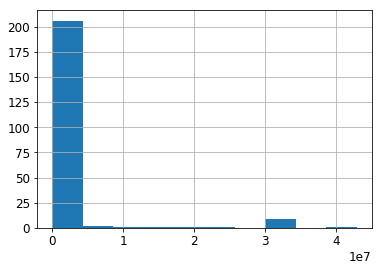

In [67]:
df_analys.Y.hist()

In [70]:
df_analys[df_analys.Y >= 42000000]['Y'].count()

1

In [71]:
df_analys[df_analys.Y >= 1000000]['Y'].count()

38

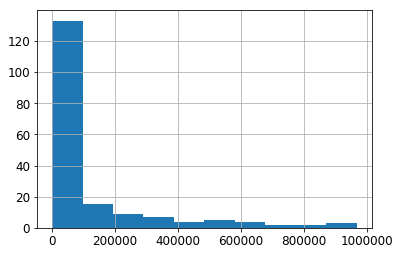

In [74]:
df_analys[df_analys.Y <= 1000000]['Y'].hist()

In [76]:
# Testar med att ta bort alla över 1 MSEK, hur blir regressionen
df_analys = df_analys[df_analys.Y <= 1000000]




### In order to avoid overfitting data is split into training data and validation data. 75% träningsdata och 25% valideringsdata

In [41]:
df_analys['is_train']=np.random.uniform(0,1,len(df_analys))<=0.75

train, validate = df_analys[df_analys['is_train']==True], df_analys[df_analys['is_train']==False]

In [42]:
type(train)

pandas.core.frame.DataFrame

In [62]:
train

,Y,VLP,V75PROC,VLP,SVLP,VSVLP,VPN_SUM,VPN_SUM_ORD,VPK_SUM,VPK_SUM_ORD,...,A_R,T_R,SP_R,ToR,P_R,TK_R,Ex_R,R_R,Ts_R,is_train
Datum,,,,,,,,,,,,,,,,,,,,,
2016-05-21,588589,22.451581,0.013802,22.451581,5.572193,0.237253,0.097701,15.245559,0.166489,194.492623,...,0.892653,0.764228,NaN,NaN,0.843270,NaN,NaN,NaN,0.944294,True
2016-05-29,27288,68.394212,0.014008,68.394212,4.949487,0.984076,0.164855,13.269618,0.170398,145.134809,...,1.022535,1.045070,NaN,NaN,1.045070,NaN,NaN,NaN,1.045070,True
2016-06-04,75003,90.679394,0.015556,90.679394,3.705457,0.924968,0.226154,13.632604,0.281173,91.944976,...,0.963431,0.911141,NaN,NaN,0.884484,NaN,NaN,NaN,0.988038,True
2016-06-11,5996,20.386267,0.011668,20.386267,6.556960,0.247386,0.106392,16.553643,0.186686,104.021801,...,0.854131,0.927711,NaN,NaN,0.927711,NaN,NaN,NaN,0.927711,True
2016-06-12,13731,33.672498,0.014507,33.672498,5.506889,0.122724,0.090778,16.910631,0.276415,159.386306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,True
2016-06-18,11277,59.331545,0.014520,59.331545,1.146538,0.208877,0.081850,14.465472,0.108606,129.608287,...,0.935939,0.935939,NaN,NaN,0.935939,NaN,NaN,NaN,0.935939,True
2016-07-02,19594,33.110512,0.013727,33.110512,1.875508,0.179300,0.168590,18.115123,0.199681,88.761111,...,0.952778,0.952778,NaN,NaN,0.952778,NaN,NaN,NaN,0.952778,True
2016-07-07,4361,278.262563,0.018862,278.262563,7.503391,0.033600,0.143183,13.878517,0.142244,59.247229,...,1.065217,1.065217,NaN,NaN,1.065217,NaN,NaN,NaN,1.065217,True
2016-07-09,1416,23.959375,0.014074,23.959375,4.084024,0.083614,0.153470,13.215190,0.147057,185.167089,...,0.961392,0.961392,NaN,NaN,0.961392,NaN,NaN,NaN,0.961867,True


In [43]:
len(validate)

53

### Nu skapar vi arrayer som ska användas av modellen - använder den skapade Pipelineobjektet som gör alla nödvändiga dataransformationer 

In [45]:
# Träningssdata
# Alla förklaringsvaribler i en multidimensionell array där kategrisvaribler har gjorts om till
# dummyvariabler
features_train = full_pipeline.fit_transform(train)
## En array som håller det vi vill predikter
label_train = train["Y"].copy()

In [64]:
label_train

Datum
2016-05-21      588589
2016-05-29       27288
2016-06-04       75003
2016-06-11        5996
2016-06-12       13731
2016-06-18       11277
2016-07-02       19594
2016-07-07        4361
2016-07-09        1416
2016-07-23       53649
2016-07-24       79271
2016-07-26       33963
2016-07-30     4081602
2016-08-06     3214228
2016-08-07       53597
2016-08-13        2842
2016-08-17      542935
2016-08-20       34408
2016-08-27     3566236
2016-09-03        1165
2016-09-04         725
2016-09-17        1099
2016-09-24        3193
2016-09-25       59658
2016-10-01        3660
2016-10-08    30000000
2016-10-15       49279
2016-10-22       13909
2016-11-06      859851
2016-11-12       10118
                ...   
2018-08-22      595929
2018-08-23       18291
2018-08-25       80996
2018-08-26         938
2018-09-01       27269
2018-09-02       10055
2018-09-15        3436
2018-09-16       65027
2018-09-22       26834
2018-09-29        2153
2018-10-20       74058
2018-10-27         233
2018-

In [46]:
# Valideringsdata
# Alla förklaringsvaribler i en multidimensionell array där kategrisvaribler har gjorts om till
# dummyvariabler
features_validate = full_pipeline.fit_transform(validate)
## En array som håller det vi vill predikter
label_validate = validate["Y"].copy()

# Train the model on the training data and then evaluate on the validation data

- predicts: A twodimensional array that contains posterrior probabbility for a donation behaviour, one for non-donation and one for donation
- fpr : False positive rate, number of false positive for a specific threshold value
- tpr : True positive rate, number of true positive for a specific threshold value
- threshold: Sorted threshold (descending) values for the likelihod to donate
- roc_auc: Receiver operating characteristics. A value close to 1 indicates a strong model. A value close to 0.5 means that the model is rather poor

In [63]:
# Bygger random forrest och analyserar roc_auc
# Instansierar modellen


rf = DecisionTreeRegressor()

# Tränar modellen

rf.fit(features_train,label_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [77]:
prepared = full_pipeline.fit_transform(df_analys)
## En array som håller det vi vill predikter
labels = df_analys["Y"].copy()

In [80]:
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(rf , prepared , labels , scoring = "neg_mean_squared_error", cv = 5 ) 
tree_rmse_scores = np.sqrt(-scores)

In [81]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [275126.44059812 266733.30396454 337077.23526042 392356.15042107
 327932.47949866]
Mean: 319845.1219485618
Standard deviation: 45696.44625737995


In [82]:
df_analys["Y"].mean()

120512.40760869565

In [83]:
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(rf , prepared , labels , scoring = "r2", cv = 5 ) 

In [84]:
scores

array([-1.17346342, -0.83347705, -1.06563385, -0.76635971, -2.89810566])